In [3]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import random

from keras import layers
from keras import Sequential, initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import L2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import LearningRateScheduler

## Long Short-Term Memory

We will use Long Short-Term Memory (LSTM) to predict stock prices. For this project, we will not be comparing predictions between companies, but instead focusing on improving model performance for a particular company. We will use JPMorgan Chase as the subject of this project.

### Scraping Data

In [7]:
ticker = 'JPM'
start_date = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2020, 1, 1, 23, 59).timetuple()))
interval = '1d' # 1d, 1wk, 1m, 1y

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true'

JPM_data = pd.read_csv(query_string, header=0, index_col=0, parse_dates=True)

### Data Preparation

In [8]:
close_data = JPM_data['Close'] # Target prediction
JPM_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,41.790001,42.990002,41.669998,42.849998,30.279608,35460500
2010-01-05,42.790001,43.840000,42.779999,43.680000,30.866123,41208300
2010-01-06,43.450001,44.090000,43.310001,43.919998,31.035719,27729000
2010-01-07,43.790001,45.119999,43.610001,44.790001,31.650503,44864700
2010-01-08,44.369999,44.700001,44.080002,44.680000,31.572777,33110100


First we normalize the data to reduce the impact of features with large values, mitigate the amount of bias we get from relatively extreme values, and help achieve rapid convergece.

In [9]:
# Using MinMaxScaler to scale data between 0 and 1

values = close_data.values
training_split = int(np.ceil(len(values)*0.8))
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_split, :]

The prediction of stock prices the next day will be based on historical data from 60 days prior. In the context of code, this means that each sequence of input features will consist of the most recent 60 days of close prices.

In [10]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [11]:
# Split 80% of the raw data to be training data

X_train, y_train = lstm_split(train_data, 60)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
# Split 20% of the raw data to be validation data

valid_data = scaled_data[training_split:, :]

X_valid, y_valid = lstm_split(valid_data, 60)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [13]:
# Preparing test data for evaluation purposes

test_data = scaled_data[training_split-60: , : ]
x_test = []
y_test = values[training_split:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In order to test accuracy without the bias of familiar data to the model, we will use a separate dataset imported from the future (relative to the time period the training datset is in) for testing.

In [142]:
# Importing new testing data for performance evaluation

start_date1 = int(time.mktime(datetime.datetime(2020, 1, 2, 23, 59).timetuple()))
end_date1 = int(time.mktime(datetime.datetime(2023, 4, 2, 23, 59).timetuple()))
JPM_query = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={start_date1}&period2={end_date1}&interval={interval}&events=history&includeAdjustedClose=true'

test_data_new = pd.read_csv(JPM_query, header=0, index_col=0, parse_dates=True)

close_data_new = test_data_new['Close']
values_new = close_data_new.values # Target values
scaled_data_new = scaler.transform(values_new.reshape(-1,1))

In [143]:
def prepare_test_data(data, n_steps):
    x = []
    for i in range(n_steps, len(data)):
        x.append(data[i-n_steps:i, 0])
    return np.array(x)

x_test_new = prepare_test_data(scaled_data_new, 60)
x_test_new = np.reshape(x_test_new, (x_test_new.shape[0], x_test_new.shape[1], 1))

### LSTM Model

In [16]:
def lstm_model(data):
    model = Sequential()
    
    # LSTM layer with 50 units, with return_squence as true to ensure same length output
    model.add(layers.LSTM(50, return_sequences=True, input_shape=(data.shape[1], 1)))
    
    # Dropout layer to prevent overfitting
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(100, return_sequences=True))
    
    model.add(layers.Dropout(0.2))
    
    # LSTM layer, with return_sequence as false to only return last output 
    model.add(layers.LSTM(50, return_sequences=False))
    
    model.add(layers.Dropout(0.2))
    
    # Densely connected layer with 25 units which is then fed into 
    # another dense layer to produce one prediction
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    
    return model

### Model Training 

In [17]:
lstm = lstm_model(X_train)
lstm.summary()
lstm.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           60400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1

In [108]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

# Fit the model with 25 epochs and 32 samples per gradient
history = lstm.fit(
    X_train, 
    y_train, 
    epochs = 25, 
    batch_size = 32,
    callbacks = [checkpointer],
    validation_data = (X_valid, y_valid)
)

Epoch 1/25
61/62 [============================>.] - ETA: 0s - loss: 3.4811e-04
Epoch 1: val_loss improved from inf to 0.01015, saving model to weights_best.hdf5
62/62 [==============================] - 5s 76ms/step - loss: 3.4967e-04 - val_loss: 0.0102
Epoch 2/25
61/62 [============================>.] - ETA: 0s - loss: 7.8865e-04
Epoch 2: val_loss improved from 0.01015 to 0.00048, saving model to weights_best.hdf5
62/62 [==============================] - 5s 75ms/step - loss: 7.8839e-04 - val_loss: 4.7877e-04
Epoch 3/25
61/62 [============================>.] - ETA: 0s - loss: 4.2804e-04
Epoch 3: val_loss did not improve from 0.00048
62/62 [==============================] - 4s 66ms/step - loss: 4.2792e-04 - val_loss: 5.0099e-04
Epoch 4/25
61/62 [============================>.] - ETA: 0s - loss: 3.8818e-04
Epoch 4: val_loss did not improve from 0.00048
62/62 [==============================] - 4s 70ms/step - loss: 3.8798e-04 - val_loss: 5.5249e-04
Epoch 5/25
61/62 [========================

### Model Evaluation

In [109]:
# Evaluation using root mean squared error and mean absolute percentage error

# Generate predictions using model
predictions = lstm.predict(x_test)

# Invert the scaling in order to compare with test data
predictions = scaler.inverse_transform(predictions)

# Calculate discrepancy between prediction and test data
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_error(y_test, predictions)/np.mean(y_test)*100


print('Root mean square error:', rmse)
print('Mean absolute percentage error:', mape)

16/16 [==============================] - 0s 16ms/step
Root mean square error: 4.649216642590991
Mean absolute percentage error: 3.712627296552619


Both the rmse and mape values are acceptable, which suggests that our model is performing well across seen and unseen data. We will further investigate the prediction accuracy visually.

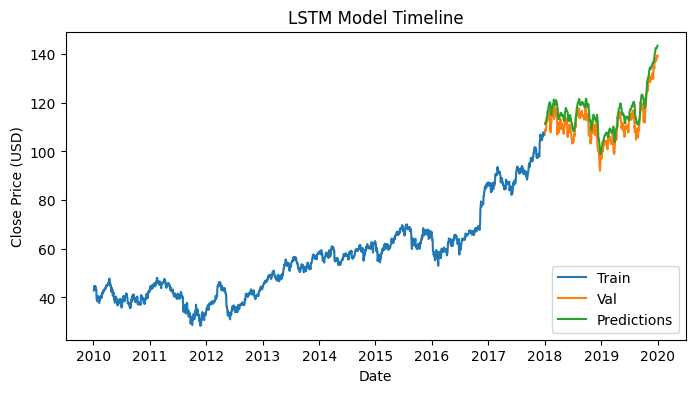

In [110]:
# Building a graph that shows training, validation and predictions on the same x-axis

data = JPM_data.filter(['Close'])
train = data[:training_split]
validation = data[training_split:].copy()  # avoid SettingWithCopyWarning
validation.loc[:, 'Predictions'] = predictions

plt.figure(figsize=(8, 4))
plt.title('LSTM Model Timeline')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

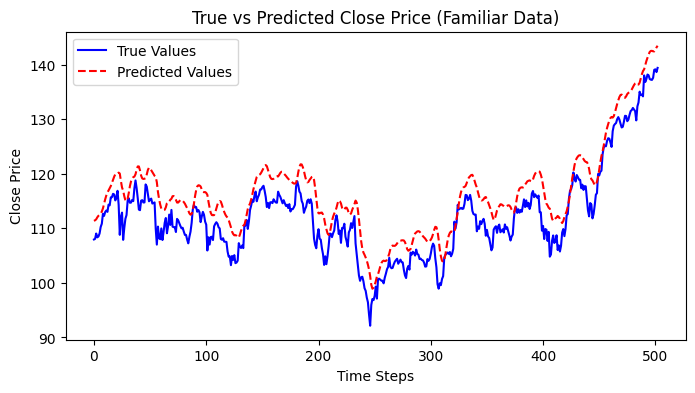

In [111]:
# Predictions against testing dataset

plt.figure(figsize=(8, 4))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('True vs Predicted Close Price (Familiar Data)')
plt.legend()
plt.show()

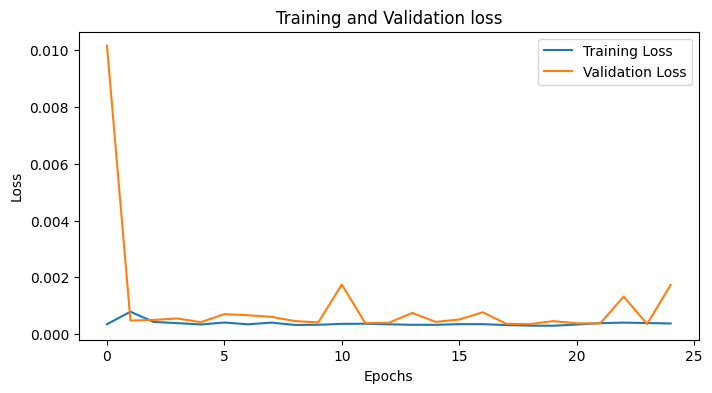

In [112]:
# Get the training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(8,4))
plt.title('Training and Validation loss')
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can see that the LSTM model is giving accurate predictions when compared to the test data. But the training and validation loss plot suggests massive overfitting.

24/24 [==============================] - 0s 18ms/step


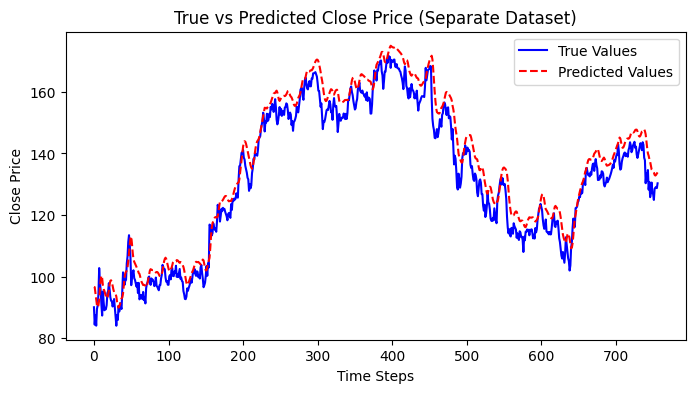

In [144]:
# Confirming overfitting issues using a separate dataset

predictions = lstm.predict(x_test_new)
predictions = scaler.inverse_transform(predictions)

y_test_new = values_new[60:]

plt.figure(figsize=(8, 4))
plt.plot(y_test_new, label='True Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('True vs Predicted Close Price (Separate Dataset)')
plt.legend()
plt.show()

The model seems to perform perfectly even on unseen data, which implies a lack of overfitting. However, the validation loss proves there are underlying issues with the model, so we will try overfitting counter-measures anyway.

### Improving Model Performance

Attempt to implement Early Stopping, L2 Regularization, and Droupout to try to improve model performance. New model has more units per layer to account for possible lack of complexity due to excessive counter-overfitting.

In [101]:
def lstm_model_new(data):
    model = Sequential()
    
    # L2 regularization to prevent overfitting
    l2_reg = L2(0.001)
    
    # LSTM layer with 100 units, with return_squence as true to ensure same length output
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(data.shape[1], 1),
                          kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg, bias_regularizer=l2_reg))
    
    # Dropout to prevent overfitting
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(100, return_sequences=True,
                          kernel_regularizer=l2_reg, recurrent_regularizer=l2_reg, bias_regularizer=l2_reg))
    
    model.add(layers.Dropout(0.2))
    
    # LSTM layer, with return_sequence as false to only return last output 
    model.add(layers.LSTM(100, return_sequences=False))
    
    model.add(layers.Dropout(0.2))
    
    # Densely connected layer with 25 units which is then fed into 
    # another dense layer to produce one prediction
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    
    return model

In [102]:
# Define new model

lstm_new = lstm_model_new(X_train)
lstm_new.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [103]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Different checkpointer for this model
checkpointer_new = ModelCheckpoint(
    filepath = 'weights_best_new.hdf5', 
    verbose = 2, 
    save_best_only = True
)

# Fit the new model with 30 epochs and 32 samples per gradient
history_new = lstm_new.fit(
    X_train, 
    y_train, 
    epochs = 30, 
    batch_size = 32,
    callbacks = [checkpointer_new, early_stopping],
    validation_data = [X_valid, y_valid]
)

Epoch 1/30
61/62 [============================>.] - ETA: 0s - loss: 0.3824
Epoch 1: val_loss improved from inf to 0.25644, saving model to weights_best_new.hdf5
62/62 [==============================] - 14s 151ms/step - loss: 0.3824 - val_loss: 0.2564
Epoch 2/30
61/62 [============================>.] - ETA: 0s - loss: 0.2089
Epoch 2: val_loss improved from 0.25644 to 0.18150, saving model to weights_best_new.hdf5
62/62 [==============================] - 8s 136ms/step - loss: 0.2089 - val_loss: 0.1815
Epoch 3/30
62/62 [==============================] - ETA: 0s - loss: 0.1595
Epoch 3: val_loss improved from 0.18150 to 0.14543, saving model to weights_best_new.hdf5
62/62 [==============================] - 8s 135ms/step - loss: 0.1595 - val_loss: 0.1454
Epoch 4/30
61/62 [============================>.] - ETA: 0s - loss: 0.1334
Epoch 4: val_loss improved from 0.14543 to 0.12408, saving model to weights_best_new.hdf5
62/62 [==============================] - 8s 135ms/step - loss: 0.1334 - val_

In [114]:
predictions_new = lstm_new.predict(x_test)
predictions_new = scaler.inverse_transform(predictions_new)

rmse_new = np.sqrt(mean_squared_error(y_test, predictions_new))
mape_new = mean_absolute_error(y_test, predictions_new)/np.mean(y_test)*100

print('RMSE without countermeasures:', rmse, 'New RMSE:', rmse_new)
print('MAPE without countermeasures:', mape, 'New MAPE:', mape_new)

16/16 [==============================] - 0s 23ms/step
RMSE without countermeasures: 4.649216642590991 New RMSE: 3.1078301621855453
MAPE without countermeasures: 3.712627296552619 New MAPE: 2.216605800170446


Both the rmse and mape values of the new model are slightly lower than the first, which means that our model certainly performs better than the first model on both seen and unseen data. The improvement in accuracy however, may not be significant.

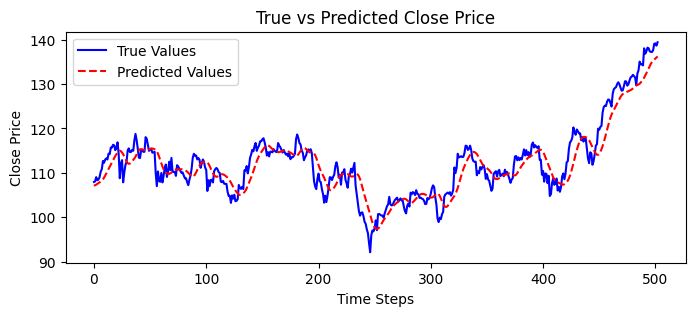

In [105]:
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='True Values', color='blue')
plt.plot(predictions_new, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.title('True vs Predicted Close Price')
plt.legend()
plt.show()

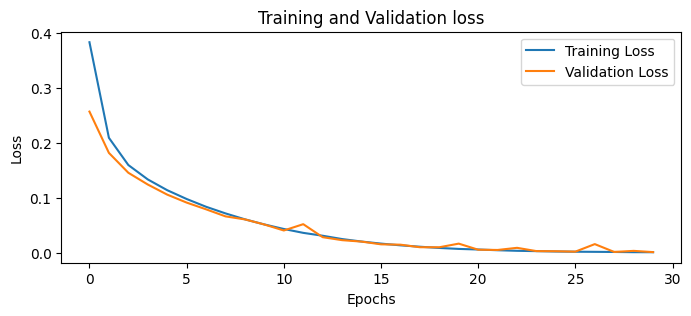

In [106]:
# Get the training and validation loss history
train_loss_new = history_new.history['loss']
val_loss_new = history_new.history['val_loss']

# Create the plot
plt.figure(figsize=(8,3))
plt.title('Training and Validation loss')
plt.plot(train_loss_new, label='Training Loss')
plt.plot(val_loss_new, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

24/24 [==============================] - 1s 28ms/step


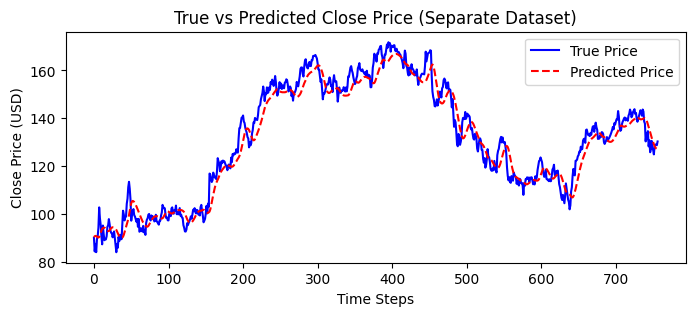

In [107]:
predictions_new = lstm_new.predict(x_test_new)
predictions_new = scaler.inverse_transform(predictions_new)

plt.figure(figsize=(8, 3))
plt.plot(y_test_new, label='True Price', color='blue')
plt.plot(predictions_new, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price (USD)')
plt.title('True vs Predicted Close Price (Separate Dataset)')
plt.legend()
plt.show()

The validation loss curve for this model is more appropriate than the previous, which shows that our overfitting measures have been beneficial to model performance. The comparison plots also show that the accuracy of our model is excellent, which further reinforces the benefits of counter-overfitting.

### Walk-forward validation

We use TimeSeriesSplit to split the training data into multiple splits for walk-froward validation. By calculating the average RMSE and MAPE across all folds, we can get a better understanding of the model's performance on unseen data

In [116]:
# Walk-forward validation
n_splits = 12
time_series_cv = TimeSeriesSplit(n_splits=n_splits)

rmse_values = []
mape_values = []

for train_index, test_index in time_series_cv.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
    X_train_cv = X_train_cv.reshape((X_train_cv.shape[0], X_train_cv.shape[1], 1))
    X_test_cv = X_test_cv.reshape((X_test_cv.shape[0], X_test_cv.shape[1], 1))
    
    lstm_split = lstm_model_new(X_train_cv)
    lstm_split.compile(optimizer='adam', loss='mean_squared_error')
    lstm_split.fit(X_train_cv, y_train_cv, epochs=25, batch_size=32, verbose=0)

    predictions_cv = lstm_split.predict(X_test_cv)
    predictions_cv = scaler.inverse_transform(predictions_cv)
    y_test_cv = scaler.inverse_transform(y_test_cv.reshape(-1, 1))

    rmse = np.sqrt(np.mean((predictions_cv - y_test_cv)**2))
    mape = np.mean(np.abs((y_test_cv - predictions_cv) / y_test_cv)) * 100
    
    rmse_values.append(rmse)
    mape_values.append(mape)

# Calculate average performance across all folds
mean_rmse = np.mean(rmse_values)
mean_mape = np.mean(mape_values)

print(f"Average RMSE across {n_splits} folds: {mean_rmse}")
print(f"Average MAPE across {n_splits} folds: {mean_mape}")


5/5 [==============================] - 2s 33ms/step
Average RMSE across 12 folds: 2.5205045086277442
Average MAPE across 12 folds: 4.180248075590192


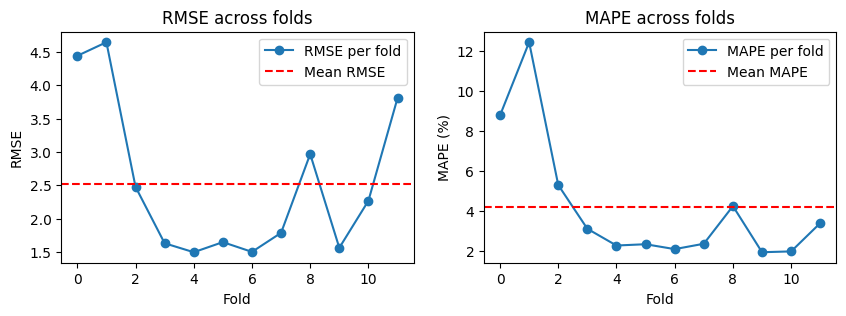

Standard deviation of RMSE values: 1.125997354478749
Standard deviation of MAPE values: 3.118551137167178


In [117]:
# Visualize RMSE and MAPE across folds

plt.figure(figsize=(10, 3))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(rmse_values, marker='o', label='RMSE per fold')
plt.axhline(mean_rmse, color='r', linestyle='--', label='Mean RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE across folds')
plt.legend()

# MAPE plot
plt.subplot(1, 2, 2)
plt.plot(mape_values, marker='o', label='MAPE per fold')
plt.axhline(mean_mape, color='r', linestyle='--', label='Mean MAPE')
plt.xlabel('Fold')
plt.ylabel('MAPE (%)')
plt.title('MAPE across folds')
plt.legend()

plt.show()

std_rmse = np.std(rmse_values)
std_mape = np.std(mape_values)

print(f"Standard deviation of RMSE values: {std_rmse}")
print(f"Standard deviation of MAPE values: {std_mape}")

From the plots we can roughly conclude that MAPE decreases as the number of folds increases, but RMSE demonstrates an inconsistent trend. This suggests that the current model would greatly benefit from having more samples in the training dataset.

However, since we are predicting stock prices, without the introduction of new data, we cannot use bagging or other random selection techniques to increase training data. To this end, the final step is to combine simple models with the current LSTM model to create an ensemble learner, which may improve accuracy.

### Ensemble Methods

Simple ensemble using model averaging, we will use an mlp model, linear regression model, and the current lstm model for training and predicting. We will take the average of all predictions as the final prediciton. Most ensemble methods are computationally expensive, but the cost of this simple ensemble should be acceptable in most situations.

In [121]:
# Functions to create models, traing each model, and then find final prediction

# Multi-layer perceptron model
def create_mlp_model(data):
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(data.shape[1], 1)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Linear regression model
def train_linear_regression(X_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    return lr_model

# Training each of the models separately, but on the same data
def train_ensemble_models(X_train, y_train, X_valid, y_valid, checkpointer, early_stopping):
    # Train LSTM model
    lstm_model = lstm_model_new(X_train)
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_model.fit(X_train, y_train, epochs=35, batch_size=32, callbacks=[checkpointer, early_stopping], validation_data=[X_valid, y_valid])

    # Train MLP model
    mlp_model = create_mlp_model(X_train)
    mlp_model.compile(optimizer='adam', loss='mean_squared_error')
    mlp_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=35, batch_size=32)

    # Train linear regression model
    lr_model = train_linear_regression(X_train, y_train)

    return lstm_model, mlp_model, lr_model

# Predicts using each model and averages the predictions
def ensemble_predict(lstm_model, mlp_model, lr_model, X_test):
    lstm_prediction = lstm_model.predict(X_test)
    mlp_prediction = mlp_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
    lr_prediction = lr_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(-1, 1)

    # Average the predictions from all three models
    avg_predictions = (lstm_prediction + mlp_prediction + lr_prediction)/3.0

    return avg_predictions

In [122]:
# Train the ensemble models and make predictions

lstm_checkpointer = ModelCheckpoint(filepath='weights_best_ensemble.hdf5', verbose=2, save_best_only=True)
lstm_early_stopping = EarlyStopping(monitor='val_loss', patience=5)

lstm_model, mlp_model, lr_model = train_ensemble_models(X_train, y_train, X_valid, y_valid, lstm_checkpointer, lstm_early_stopping)

ensemble_predictions = ensemble_predict(lstm_model, mlp_model, lr_model, x_test)

Epoch 1/35
62/62 [==============================] - ETA: 0s - loss: 0.3804
Epoch 1: val_loss improved from inf to 0.25572, saving model to weights_best_ensemble.hdf5
62/62 [==============================] - 16s 158ms/step - loss: 0.3804 - val_loss: 0.2557
Epoch 2/35
62/62 [==============================] - ETA: 0s - loss: 0.2072
Epoch 2: val_loss improved from 0.25572 to 0.18038, saving model to weights_best_ensemble.hdf5
62/62 [==============================] - 10s 153ms/step - loss: 0.2072 - val_loss: 0.1804
Epoch 3/35
62/62 [==============================] - ETA: 0s - loss: 0.1586
Epoch 3: val_loss improved from 0.18038 to 0.14430, saving model to weights_best_ensemble.hdf5
62/62 [==============================] - 12s 189ms/step - loss: 0.1586 - val_loss: 0.1443
Epoch 4/35
62/62 [==============================] - ETA: 0s - loss: 0.1326
Epoch 4: val_loss improved from 0.14430 to 0.12423, saving model to weights_best_ensemble.hdf5
62/62 [==============================] - 17s 264ms/ste

Ensemble rmse: 2.386403963764691 Rmse with counter-overfitting: 3.1078301621855453
Ensemble mape: 1.718816706477021 Mape with counter-overfitting: 2.216605800170446


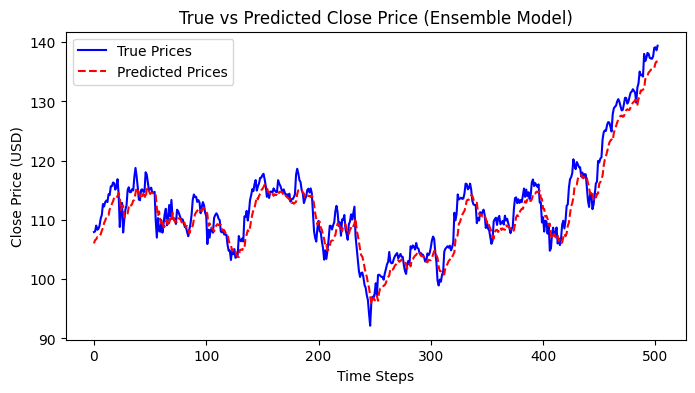

In [123]:
# Rescale the predictions back to the original price scale
ensemble_predictions_rescaled = scaler.inverse_transform(ensemble_predictions)

# Calculate the performance metrics for the ensemble model
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_predictions_rescaled))
mape_ensemble = mean_absolute_error(y_test, ensemble_predictions_rescaled) / np.mean(y_test) * 100

print('Ensemble rmse:', rmse_ensemble, 'Rmse with counter-overfitting:', rmse_new)
print('Ensemble mape:', mape_ensemble, 'Mape with counter-overfitting:', mape_new)

# Plot true vs. predicted close prices
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='True Prices', color='blue')
plt.plot(ensemble_predictions_rescaled, label='Predicted Prices', color='red', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Close Price (USD)')
plt.title('True vs Predicted Close Price (Ensemble Model)')
plt.legend()
plt.show()

The ensemble method predictions seems to be approximately accurate, with large inconsistencies occuring only at positions of rapid change. Also, the rmse and mape values suggests that this ensemble learner is much stronger and more stable than just any base lstm model.

#### References

Kaggle notebook by BryanB

https://www.kaggle.com/code/bryanb/stock-prices-forecasting-with-lstm#chap3

Medium article by Bee Guan Teo

https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827

ProjectPro article

https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571#mcetoc_1ftklmk3qp

Colah's blog

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Purdue University CS 373 Data Mining and Machine Learning lectures